In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import random
import os
import numpy as np


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()

In [3]:
res = []
for file_path in glob.glob('../data/*.csv'):
    res.append(pd.read_csv(file_path))
df = pd.concat(res).sort_values('datetime').reset_index(drop=True)

In [4]:
df.head(3)

,wrestler,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,final_opponent,datetime
0,蒼樹山,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,200001
1,金開山,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,和歌乃山,200001
2,魁皇,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,武双山,200001


In [5]:
df = df.dropna().reset_index(drop=True)

In [6]:
len(df)

4340

In [7]:
df.rename(columns={'day_15': 'final_day'}, inplace=True)
df['wins_at_day_14'] = df.iloc[:, df.columns.str.startswith('day_')].sum(axis=1)
# df.rename(columns={'final_day': 'day_15'}, inplace=True)

# features

In [8]:
df.head(2)

,wrestler,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,final_day,final_opponent,datetime,wins_at_day_14
0,金開山,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,和歌乃山,200001,6.0
1,魁皇,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,武双山,200001,7.0


## final_opponent_wins_at_day_14

In [9]:
_tmp = df[['wrestler', 'datetime', 'wins_at_day_14']].rename(columns={'wrestler': 'final_opponent', 'wins_at_day_14': 'final_opponent_wins_at_day_14'})
df = pd.merge(df, _tmp, on=['final_opponent', 'datetime'], how='left')

## wins_till_final_day

In [10]:
def calc_wins_till_final_day(row):
    cnt = 0
    for i in range(14):
        if row.iloc[14 - i] == 1:
            cnt += 1
        else:
            return cnt
    return cnt


def calc_loses_till_final_day(row):
    cnt = 0
    for i in range(14):
        if row.iloc[14 - i] == 0:
            cnt += 1
        else:
            return cnt
    return cnt


df['wins_till_final_day'] = df.apply(calc_wins_till_final_day, axis=1)
df['loses_till_final_day'] = df.apply(calc_loses_till_final_day, axis=1)

In [11]:
split_datetime = 201501
train = df[df['datetime']<split_datetime]
test = df[~(df['datetime']<split_datetime)]

In [12]:
len(test['datetime'].unique())

28

# benchmark

In [13]:
TRAIN_COL = list(df.iloc[:, df.columns.str.startswith('day_')].columns) + [
    'wins_at_day_14',
    'final_opponent_wins_at_day_14',
    'wins_till_final_day',
    'loses_till_final_day'
]
TARGET = 'final_day'

X_train = train[TRAIN_COL]
X_test = test[TRAIN_COL]

y_train = train[TARGET]
y_test = test[TARGET]

In [14]:
import pandas as pd
import lightgbm as lgb


def lgbm(X_tr, X_val, y_tr, y_val, X_test, params, categorical_features):

    lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, categorical_feature=categorical_features)

    model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        num_boost_round=10000,
        early_stopping_rounds=30,
        verbose_eval=10
    )

    y_valid = model.predict(X_val)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns.values
    fold_importance_df["importance"] = model.feature_importance(importance_type='gain')

    return y_pred, y_valid, model, fold_importance_df


/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [15]:
from sklearn.model_selection import KFold, TimeSeriesSplit
import seaborn as sns


lgbm_params = {
    'max_depth': 16,
    'num_leaves': 4,
    'min_data_in_leaf': 10,
    'objective': 'binary',
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "feature_fraction": 0.7,
    "bagging_freq": 1,
    "bagging_fraction": 0.7,
    "metric": 'auc',
    "lambda_l1": 0.3,
    "verbosity": -1,
    "random_state": 42,
  }

categorical_features = list(df.iloc[:, df.columns.str.startswith('day_')].columns)

METRIC = 'auc'

In [16]:
train_basho, valid_basho = np.split(train['datetime'].unique(), [59])
len(valid_basho)

28

In [17]:
y_preds = []
models = []
feature_importances = pd.DataFrame()
# oof_train = np.zeros((len(X_train),))

for split_index in range(30, 60):

    train_basho, valid_basho = np.split(train['datetime'].unique(), [split_index])
    valid_basho = valid_basho[0:28]

    X_tr = X_train[train['datetime'].isin(train_basho)]
    X_val = X_train[train['datetime'].isin(valid_basho)]

    y_tr = y_train[train['datetime'].isin(train_basho)]
    y_val = y_train[train['datetime'].isin(valid_basho)]

    y_pred, y_val, model, fold_importance_df = lgbm(
        X_tr, X_val, y_tr, y_val, X_test, lgbm_params, categorical_features
    )

#     oof_train[valid_index] = y_val
    y_preds.append(y_pred)
    models.append(model)
    feature_importances = pd.concat([feature_importances, fold_importance_df], axis=0)


/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.64598	valid_1's auc: 0.535319
[20]	training's auc: 0.672417	valid_1's auc: 0.536924
[30]	training's auc: 0.679628	valid_1's auc: 0.548367
[40]	training's auc: 0.693257	valid_1's auc: 0.547214
[50]	training's auc: 0.696513	valid_1's auc: 0.541035
[60]	training's auc: 0.707353	valid_1's auc: 0.543888
Early stopping, best iteration is:
[34]	training's auc: 0.682773	valid_1's auc: 0.553034
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.650219	valid_1's auc: 0.536764
[20]	training's auc: 0.670612	valid_1's auc: 0.544571
[30]	training's auc: 0.67419	valid_1's auc: 0.554709
[40]	training's auc: 0.688106	valid_1's auc: 0.561926
[50]	training's auc: 0.696728	valid_1's auc: 0.556213
[60]	training's auc: 0.706148	valid_1's auc: 0.556727
Early stopping, best iteration is:
[33]	training's auc: 0.677284	valid_1's auc: 0.565401
Training until validation scores don't improve for 3

[50]	training's auc: 0.65691	valid_1's auc: 0.553372
[60]	training's auc: 0.669536	valid_1's auc: 0.550792
[70]	training's auc: 0.677528	valid_1's auc: 0.548181
Early stopping, best iteration is:
[44]	training's auc: 0.653512	valid_1's auc: 0.559627
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.616191	valid_1's auc: 0.533396
[20]	training's auc: 0.638358	valid_1's auc: 0.540651
[30]	training's auc: 0.648322	valid_1's auc: 0.545029
[40]	training's auc: 0.658592	valid_1's auc: 0.554596
[50]	training's auc: 0.662962	valid_1's auc: 0.554103
[60]	training's auc: 0.673681	valid_1's auc: 0.550845
[70]	training's auc: 0.68294	valid_1's auc: 0.541562
Early stopping, best iteration is:
[45]	training's auc: 0.659734	valid_1's auc: 0.55715
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.623798	valid_1's auc: 0.542364
[20]	training's auc: 0.63546	valid_1's auc: 0.548205
[30]	training's auc: 0.640891	valid_1's auc: 0.551401


In [18]:
scores = [
    m.best_score['valid_1'][METRIC] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(score)
print(scores)

===CV scores===
0.561075309780923
[0.553033977312532, 0.5654011499993251, 0.5770425426630289, 0.5625791128699151, 0.5693799978604477, 0.5698882215548883, 0.5627532601488249, 0.5608446576072476, 0.560868220806109, 0.551473063973064, 0.5511221819645733, 0.5435133961190481, 0.5495378742214185, 0.5517955801104972, 0.5563276153177545, 0.5502257073715562, 0.5591984763219368, 0.5596266230528353, 0.5571498602223194, 0.5622469332801436, 0.5600356990622336, 0.5577421670888095, 0.5757306807964246, 0.5757692307692308, 0.5707971713275474, 0.5693833931523975, 0.5571029142918593, 0.56085019259699, 0.5589869253336499, 0.5718524662310843]


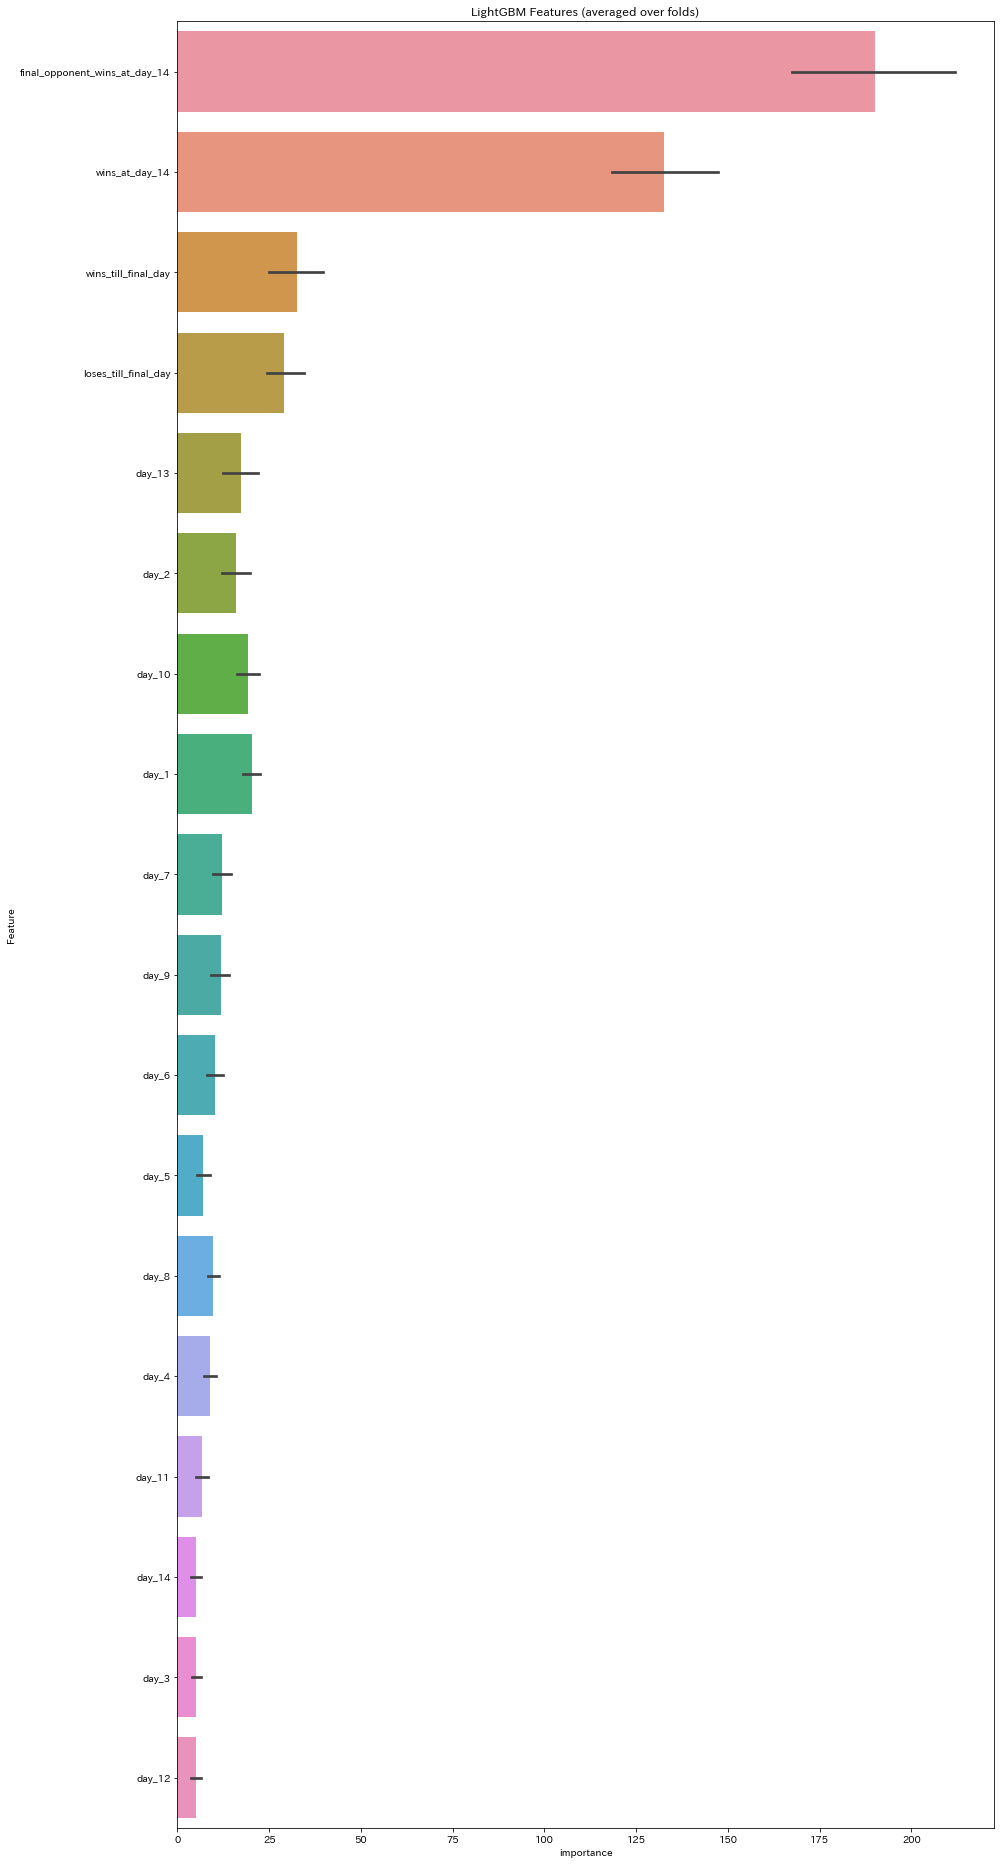

In [19]:
cols = feature_importances.groupby('Feature').mean().sort_values(by="importance", ascending=False)[:200].index

best_features = feature_importances.loc[feature_importances.Feature.isin(cols)]
plt.figure(figsize=(14, 26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [20]:
y_sub = sum(y_preds) / len(y_preds)
y_sub[:10]

array([0.50996899, 0.38365022, 0.48725235, 0.4154235 , 0.47479715,
       0.4252278 , 0.54301298, 0.50624906, 0.65221191, 0.45144476])

(array([ 16.,  55., 142., 219., 270., 201.,  90.,  32.,  22.,   3.]),
 array([0.33134243, 0.36977251, 0.4082026 , 0.44663268, 0.48506276,
        0.52349284, 0.56192292, 0.600353  , 0.63878308, 0.67721316,
        0.71564325]),
 <a list of 10 Patch objects>)

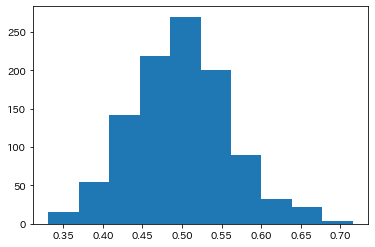

In [21]:
plt.hist(y_sub)

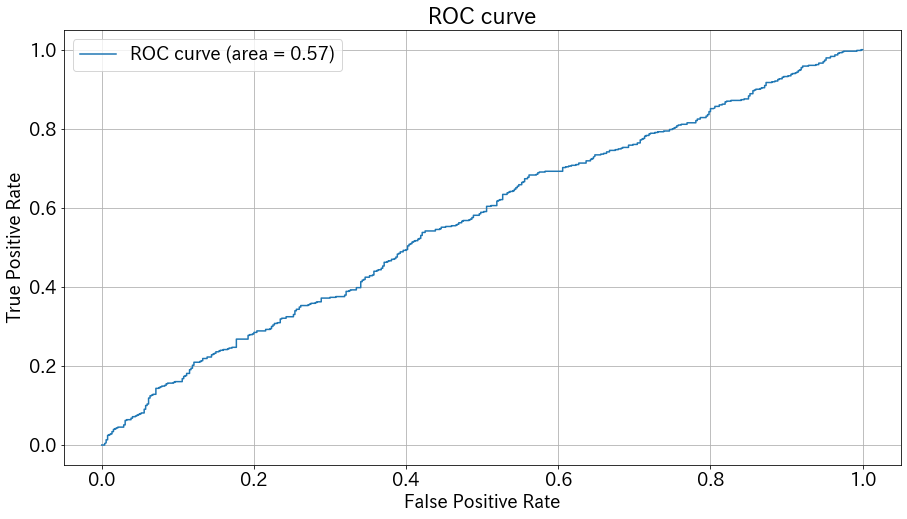

In [22]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_sub)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15, 8))
plt.rcParams["font.size"] = 18
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [23]:
y_sub = np.where(y_sub > 0.5, 1, 0)
y_sub[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0])

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_sub)

array([[299, 221],
       [245, 285]])

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_sub)

0.5561904761904762